In [193]:
import json

# Load JSON file
with open('data.json', 'r') as f:
    jsonStr = f.read()

# Parse JSON string
data = json.loads(jsonStr)

In [194]:
import matplotlib.pyplot as plt
import numpy as np

In [195]:
disp = np.array(data['disp'])
vel = np.array(data['vel'])
acc = np.array(data['acc'])
Ad = np.array(data['Ad'])
Bd = np.array(data['Bd'])
Cd = np.array(data['Cd'])
Dd = np.array(data['Dd'])
u = np.array(data['u'])

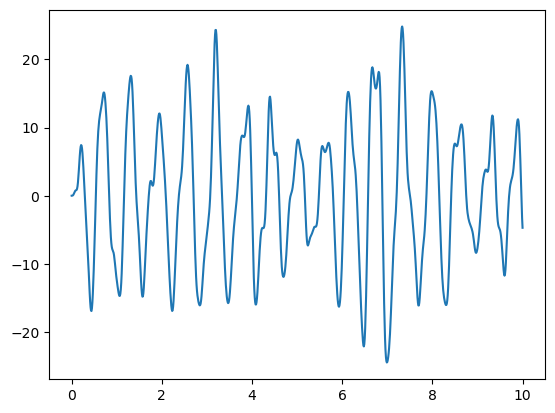

In [196]:
plt.plot(np.arange(0,10.01,0.01),acc)

In [200]:
u = u.reshape(1001,1)
Bd = Bd.reshape(2,1)
state = [0]*1001
for i in range(0,1000):
    state[0] = [disp[0], vel[0]]
    state[i+1] = np.matmul(Ad, state[i])  + np.matmul(Bd, u[i])
    

(2,)

In [203]:
state = np.array(state)

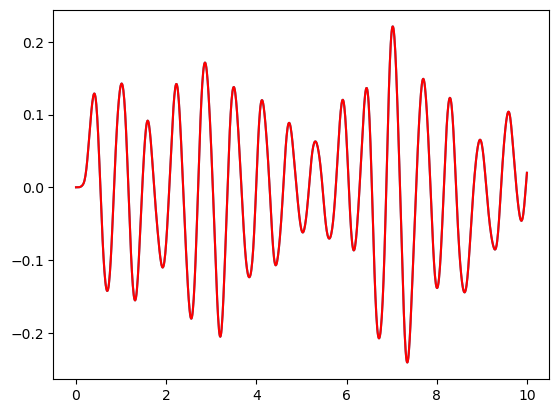

In [204]:
plt.plot(np.arange(0,10.01,0.01),state[:,0] )
plt.plot(np.arange(0,10.01,0.01),disp, c='r')

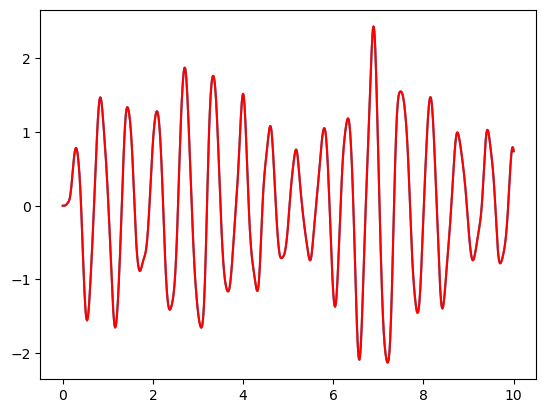

In [205]:
plt.plot(np.arange(0,10.01,0.01),state[:,1] )
plt.plot(np.arange(0,10.01,0.01),vel, c='r')

In [206]:
import control as ct

In [227]:
import numpy as np
from scipy.signal import butter, filtfilt
from scipy.linalg import expm
from scipy import signal

def gen_ss(thetaVec):
    m = np.exp(thetaVec[0])
    k = np.exp(thetaVec[1])
    c = np.exp(thetaVec[2])

    ndof = 1

    Ac = np.array([[0, 1],
                   [-k/m, -c/m]])

    Bc = np.array([[0],
                   [1 / m]])

    getidx = np.arange(ndof, 2 * ndof)
    C = Ac[getidx, :]

    D = Bc[getidx, :]

    return Ac, Bc, C, D

ndof = 1
dt = 0.01  # sampling period
fs = 1 / dt
T = 10  # final time
t = np.arange(0, T + dt, dt)  # time samples

# force
np.random.seed(23)
utmp = 10 * np.random.randn(len(t))
b, a = butter(5, 5 / (fs / 2), 'low')
u = filtfilt(b, a, utmp)

true_m = 1
true_k = 100
true_c = 0.4
zeta = true_c / (2 * true_m * np.sqrt(true_k / true_m))
true_theta = np.array([true_m, true_k, true_c])
Ac, Bc, C, D = gen_ss(np.log(true_theta))

# Convert continuous to discrete
Cfull = np.vstack((np.eye(2 * ndof), C))
Dfull = np.array([[0], [0], [1 / true_m]])
sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
sysd = sysc.to_discrete(dt)
Ad = sysd.A
Bd = sysd.B

#Ad_analytical = expm(Ac*dt) (Checks out)
Bd_analyt = np.linalg.solve(Ac, (Ad - np.eye(2 * ndof)) @ Bc)



In [228]:
def get_discrete_mat(m,k,c):
    true_theta = np.array([m, k, c])
    Ac, Bc, C, D = gen_ss(np.log(true_theta))
    Cfull = np.vstack((np.eye(2 * ndof), C))
    Dfull = np.array([[0], [0], [1 / true_m]])
    sysc = signal.StateSpace(Ac, Bc, Cfull, Dfull)
    sysd = sysc.to_discrete(dt)
    Ad = sysd.A
    Bd = sysd.B
    
    return Ad, Bd, Cfull, Dfull

    

In [229]:
u = u.reshape(1001,1)

True states:

In [255]:
state = [0]*1001
obs = [0]*1001
for i in range(0,1000):
    state[0] = np.array([disp[0], vel[0]])
    state[i+1] = np.matmul(Ad, state[i])  + np.matmul(Bd, u[i])
    
    obs[i] = np.matmul(C, state[i])

0.0

In [265]:
obs = np.array(obs, dtype=float)


In [269]:
#Add noise to measurements
noise_percentage = 10;
noise_std = noise_percentage/100*(np.sqrt(np.mean(obs**2)));
noise = noise_std*np.random.randn(np.size(obs));
y = obs + noise;


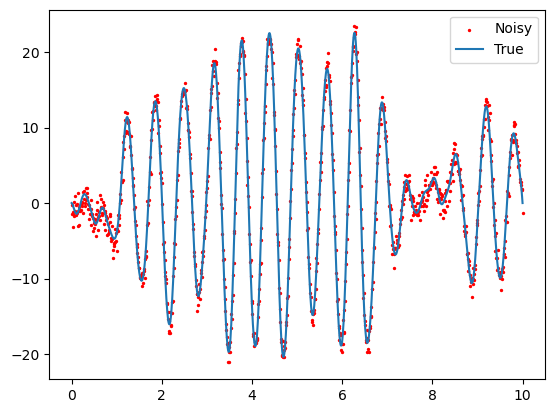

In [277]:
plt.scatter(np.arange(0,10.01,0.01),y, label='Noisy', c='r', s = 2)
plt.plot(np.arange(0,10.01,0.01), obs, label = 'True')
plt.legend()

In [247]:
state = np.array(state)


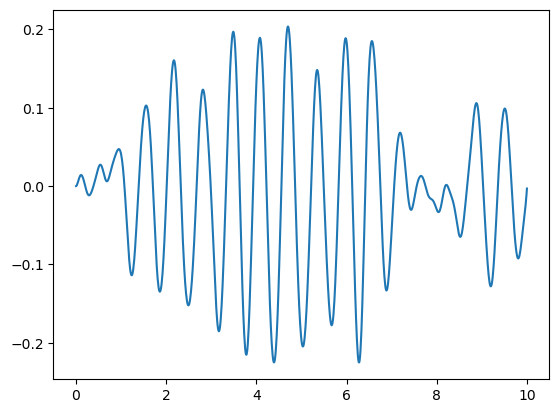

In [248]:
plt.plot(np.arange(0,10.01,0.01),state[:,0] )
#plt.plot(np.arange(0,10.01,0.01),disp, c='r')

In [289]:
def particle_filter(m_0, P_0, Q, dt, y, Ad, Bd, C, n_particles, random_state):
    
    #m0, P0 is mean and Covaraince of Prior on inital state?
    #Q is the process noise and R would be the measurement noise. Here we are trying to estimate r(R)
    steps = y.shape[0]
    chol_P0 = np.linalg.cholesky(P_0)
    chol_Q = np.linalg.cholesky(Q)
    #sd = sqrt(R)
    sqrt_R = np.sqrt(R)
    #initial state[x, x'] with mean m0 and sd = chol_P0 ?
    
    log_likelihood = 0.
    
    #N(0,R)
    frozen_dist = stats.norm(0., sqrt_R)
    
    for i in range(steps):
        # Propagate through the dynamic model: cross-term update
        state[0] = m_0.reshape(2, 1) + np.matmul(chol_P0, random_state.randn(2, n_particles))
        state[i+1] = np.matmul(Ad, state[i])  + np.matmul(Bd, u[i])
        
        # Add the process noise(with choleski decomposition)
        state = state + np.matmul(chol_Q, random_state.randn(2, n_particles))
        
        # Compute the unnormalized importance weights
        obs = y[i]
        
        #measurement eq: y = np.sin(x1) i.e. np.sin(state[0,:])
        w = frozen_dist.pdf(np.matmul(C, state[i])- obs)

        log_likelihood += np.log(np.mean(w))
        # Normalize them
        w = normalise(w)
        
        # Do resampling
        ind = stratified_resampling(w, random_state)
        state = state[:, ind]
        
    return log_likelihood

In [290]:
def stratified_resampling(w, random_state):
    """ Generate non decreasing numbers x_i between [0, 1]
    """
    n_particles = w.shape[0]
    z = random_state.rand(n_particles) + np.linspace(0., n_particles - 1., n_particles)
    us = z / n_particles
    cs = np.cumsum(w)
    idx = np.searchsorted(cs, us, side='left')

    return np.clip(idx, 0, n_particles - 1)

def normalise(w):
    """Normalises the positive vector w so that it sums to 1"""
    return w / np.sum(w, axis=-1, keepdims=True)

In [291]:
m_0 = np.array([0., 0.])  # Exactly known(? MAYBE)
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])
n_particles = 100

In [294]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1
RandomState(1)

NameError: name 'RandomState' is not defined

In [293]:
particle_filter(m_0, P_0, Q, y,Ad, Bd, C, n_particles, random_state)

NameError: name 'random_state' is not defined